In [1]:
from matplotlib import pyplot as plt
from random import randint
import numpy as np
import cv2 as cv
import time

# imshow util
def imshow(img, title='img', size=(15, 15)):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.title(title)
    plt.show()

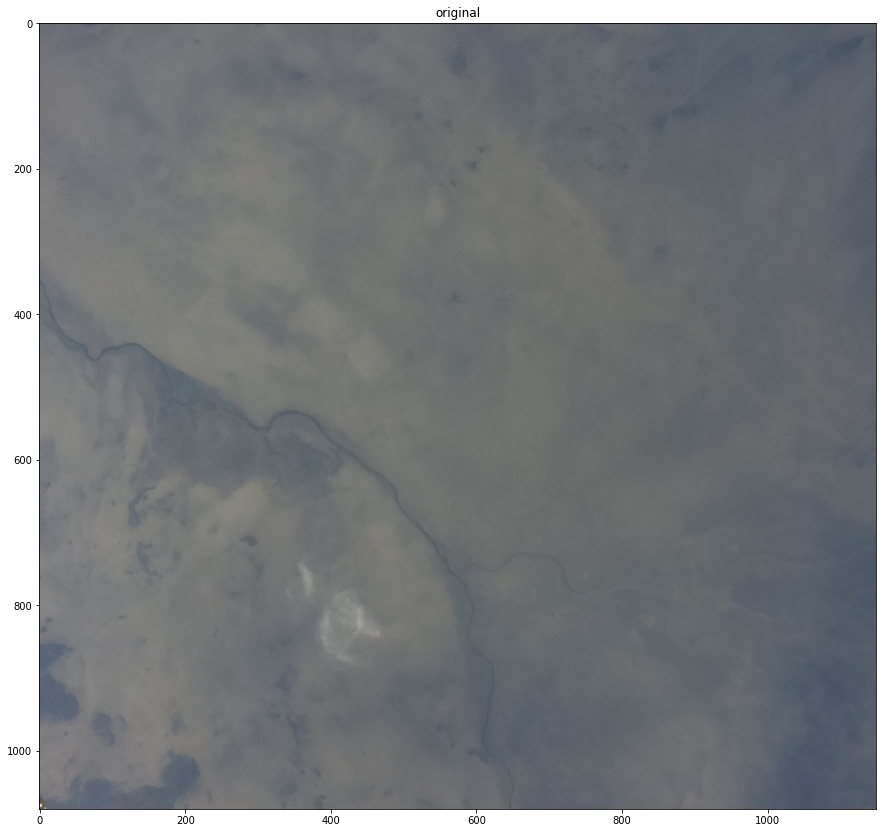

In [2]:
img = cv.imread('./data/46139865612_61080b4f33_o.jpg')
# img = cv.imread('./data/46139916742_e461092961_o.jpg')
img = img[:, 350:1500]

imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB), title='original')

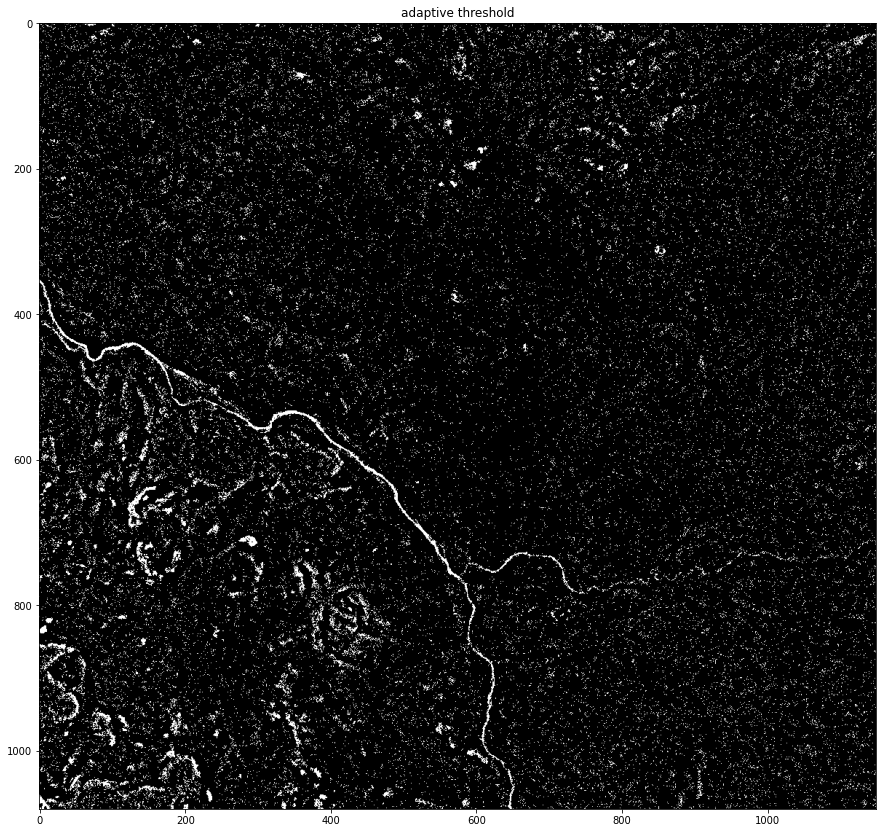

In [3]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
thr = cv.adaptiveThreshold(
    gray,
    255,
    cv.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv.THRESH_BINARY_INV,
    25,
    3
)

imshow(cv.cvtColor(thr, cv.COLOR_BGR2RGB), title='adaptive threshold')

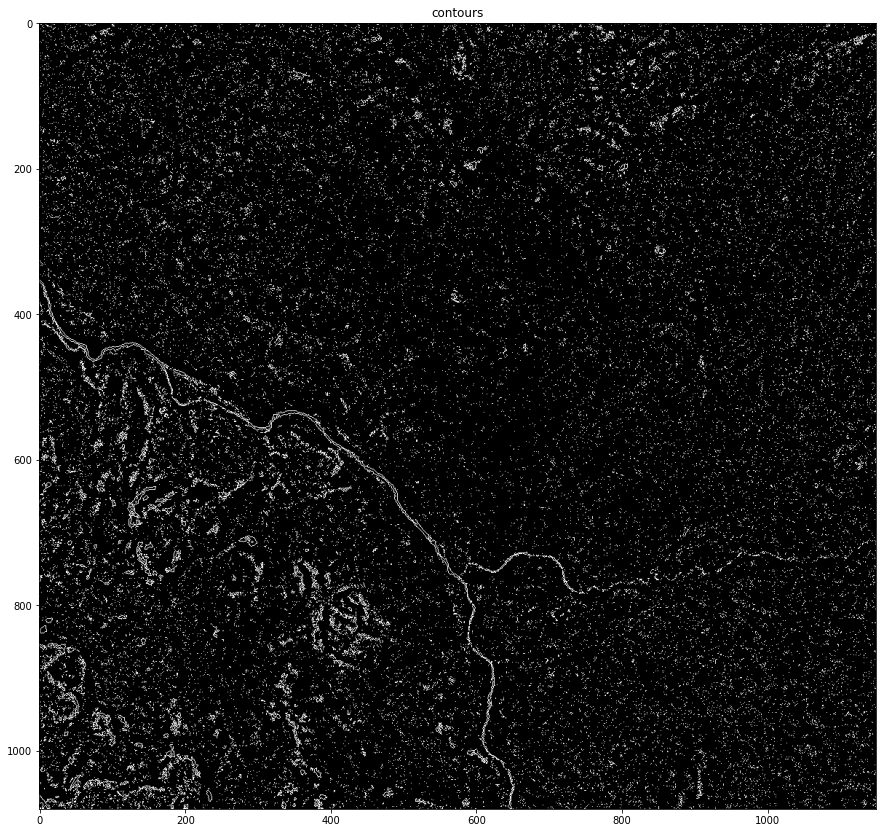

In [4]:
conts, hier = cv.findContours(
    thr,
    cv.RETR_TREE,
    cv.CHAIN_APPROX_NONE
)

exc = np.zeros(img.shape, np.uint8)
cv.drawContours(exc, conts, -1, (255, 255, 255), 1)

imshow(cv.cvtColor(exc, cv.COLOR_BGR2RGB), title='contours')

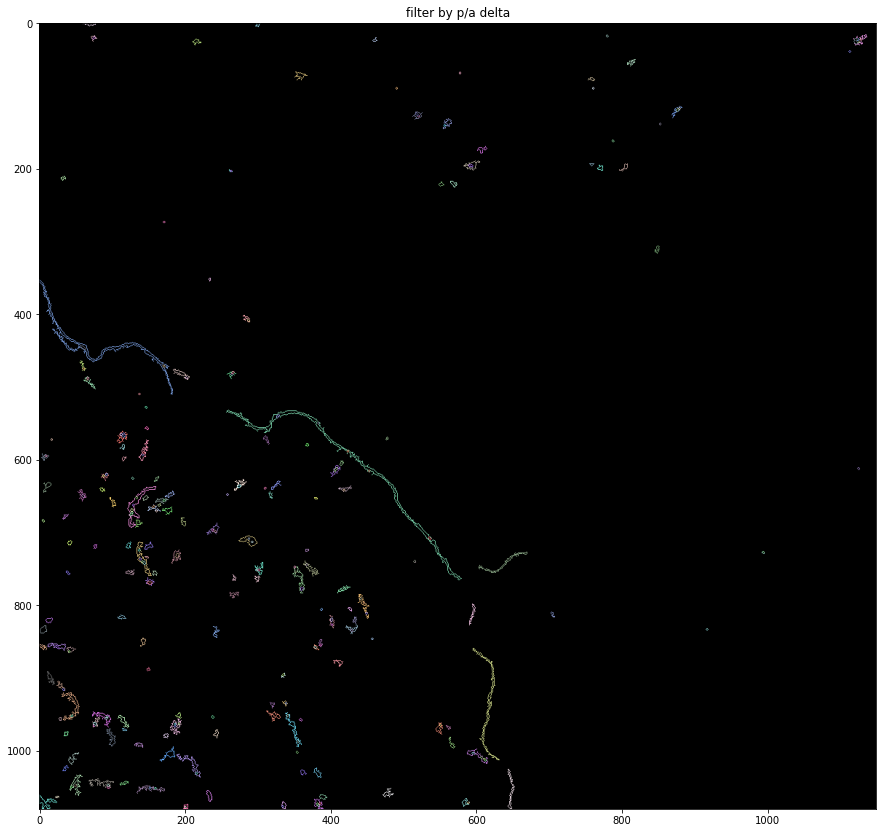

In [5]:
exc = np.zeros(img.shape, np.uint8)
lowerbound = 0
upperbound = 1

for cont in conts:
    p = cv.arcLength(cont, True)
    a = cv.contourArea(cont)
    d = abs(p/a - 1) if a > 0 else None
    if d and lowerbound <= d <= upperbound:
        randc = (randint(100, 255), randint(100, 255), randint(100, 255))
        cv.drawContours(exc, [cont], 0, randc, 1)

imshow(cv.cvtColor(exc, cv.COLOR_BGR2RGB), title='filter by p/a delta')

In [6]:
from math import sqrt

def hyp(x1, y1, x2, y2):
    return sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def split_if_too_distant(to_split, r, scale=1.5):
    splitted = []
    current = []
    for p1, p2 in (zip(to_split[:-1], to_split[1:])):
        current.append(p1)
        if hyp(*tuple(p1[0]), *tuple(p2[0])) > r * scale:
            splitted.append(current[:])
            current = []

    current.append(to_split[-1])
    splitted.append(current)

    return splitted

def clean_first(to_clean, r):
    filtered = []
    discarded = []
    
    x, y = to_clean.pop()[0]

    for point in to_clean:
        px, py = point[0]
        if hyp(x, y, px, py) > r:
            filtered.append(point)
        else:
            discarded.append(point)

    return x, y, filtered, discarded

def reduce_contour(to_filter, r):
    filtered = []
    discarded = []
    
    while len(to_filter) > 0:
        x, y, to_filter, disc = clean_first(to_filter, r=r)
        filtered.append([[x, y]])
        discarded += disc

    return split_if_too_distant(filtered, r), discarded
    
longest = max(conts, key=len)

start = time.time()
splitted, discarded = reduce_contour(longest.tolist(), 5)

print(f'Elapsed time: {round(time.time() - start, 3)}')
print(f'Reduced points: {sum(map(len, splitted))}')
print(f'Discarded points: {len(discarded)}')

Elapsed time: 0.049
Reduced points: 95
Discarded points: 869


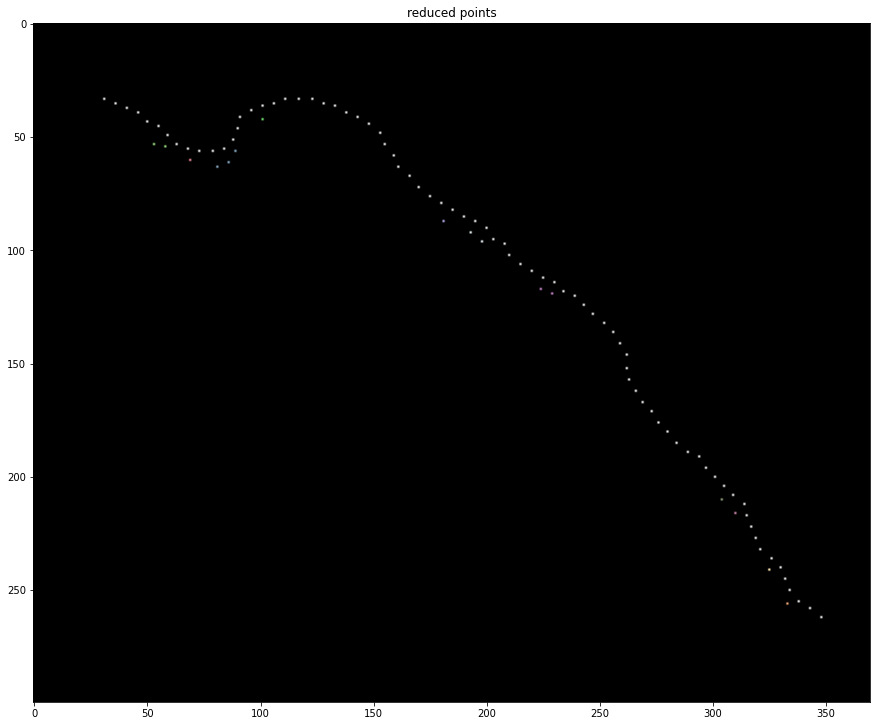

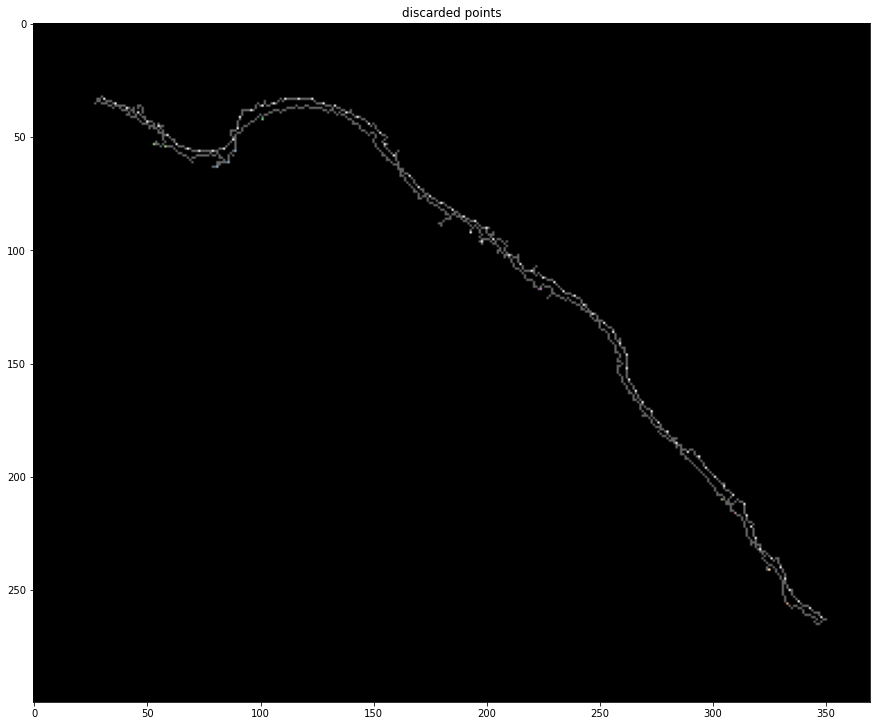

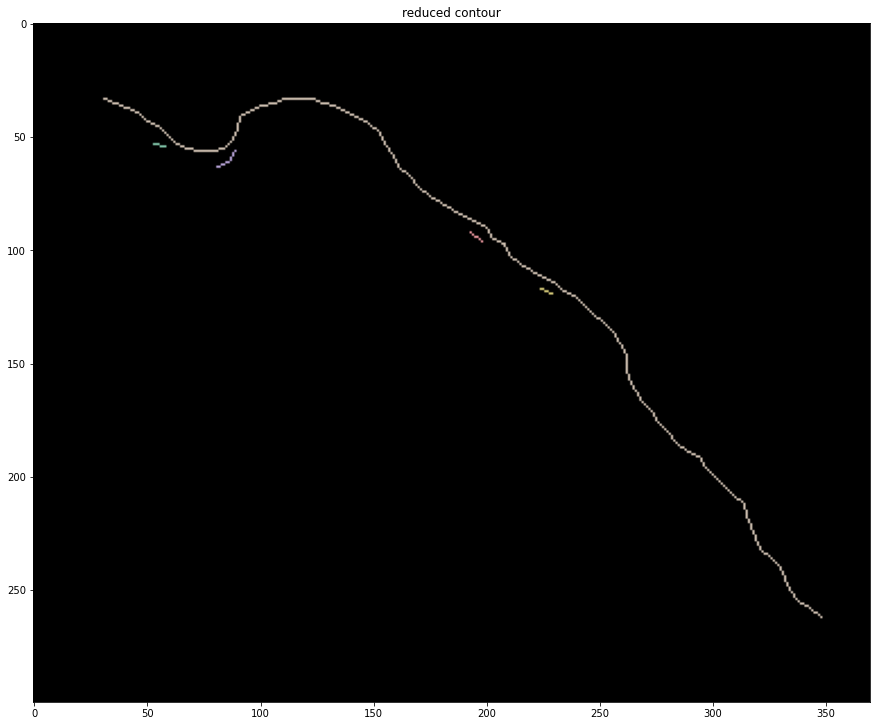

In [7]:
exc = np.zeros(img.shape, np.uint8)
excc = np.zeros(img.shape, np.uint8)

for cont in splitted:
    color = (randint(100, 255), randint(100, 255), randint(100, 255))
    for point in cont:
        cv.line(exc, tuple(point[0]), tuple(point[0]), color, 1)
imshow(cv.cvtColor(exc, cv.COLOR_BGR2RGB)[500:800, 230:600], 'reduced points')

for point in discarded:
    cv.line(exc, tuple(point[0]), tuple(point[0]), (100, 100, 100), 1)
imshow(cv.cvtColor(exc, cv.COLOR_BGR2RGB)[500:800, 230:600], 'discarded points')

def draw_contour(img, cont, color=(255, 255, 255)):
    for p1, p2 in (zip(cont[:-1], cont[1:])):
        cv.line(img, tuple(p1[0]), tuple(p2[0]), color, 1)

for cont in splitted:
    color = (randint(100, 255), randint(100, 255), randint(100, 255))
    draw_contour(excc, cont, color)
imshow(cv.cvtColor(excc, cv.COLOR_BGR2RGB)[500:800, 230:600], 'reduced contour')

Elapsed time for reducing all contours: 0.177


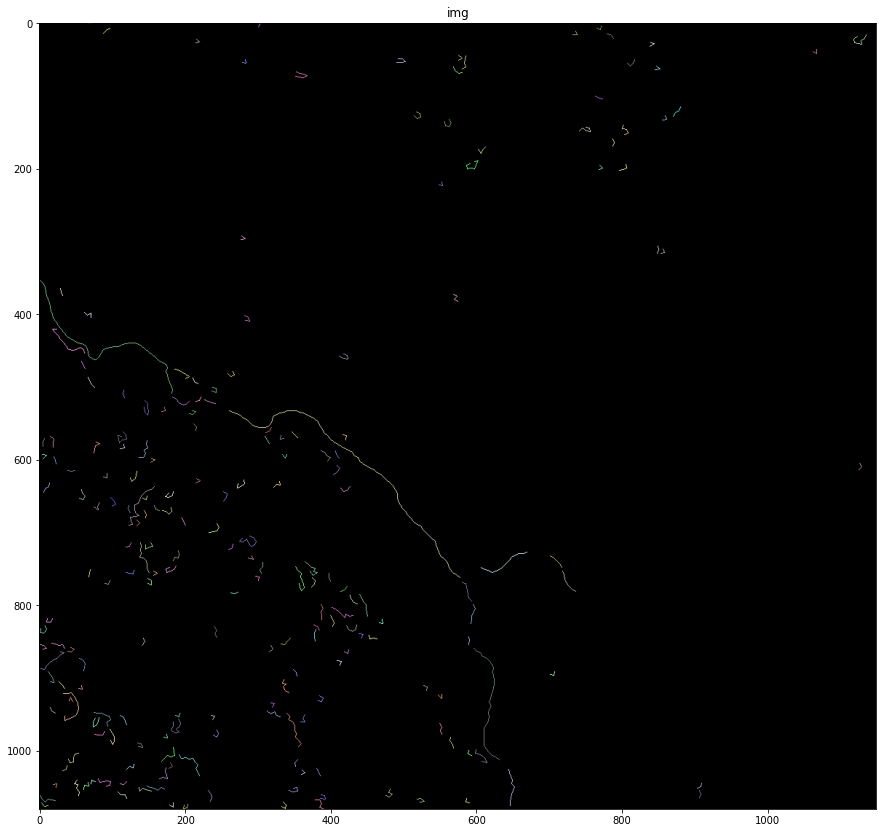

In [8]:
def contour_len(cont):
    l = 0
    for p1, p2 in (zip(cont[:-1], cont[1:])):
        l += hyp(*tuple(p1[0]), *tuple(p2[0]))
    return l

exc = np.zeros(img.shape, np.uint8)

start = time.time()
reduced_contours = []
for cont in conts:
    rconts, _ = reduce_contour(cont.tolist(), 5)
    reduced_contours += rconts
print(f'Elapsed time for reducing all contours: {round(time.time() - start, 3)}')

for cont in reduced_contours:
    color = (randint(100, 255), randint(100, 255), randint(100, 255))
    if contour_len(cont) > 10:
        draw_contour(exc, cont, color)

imshow(exc)

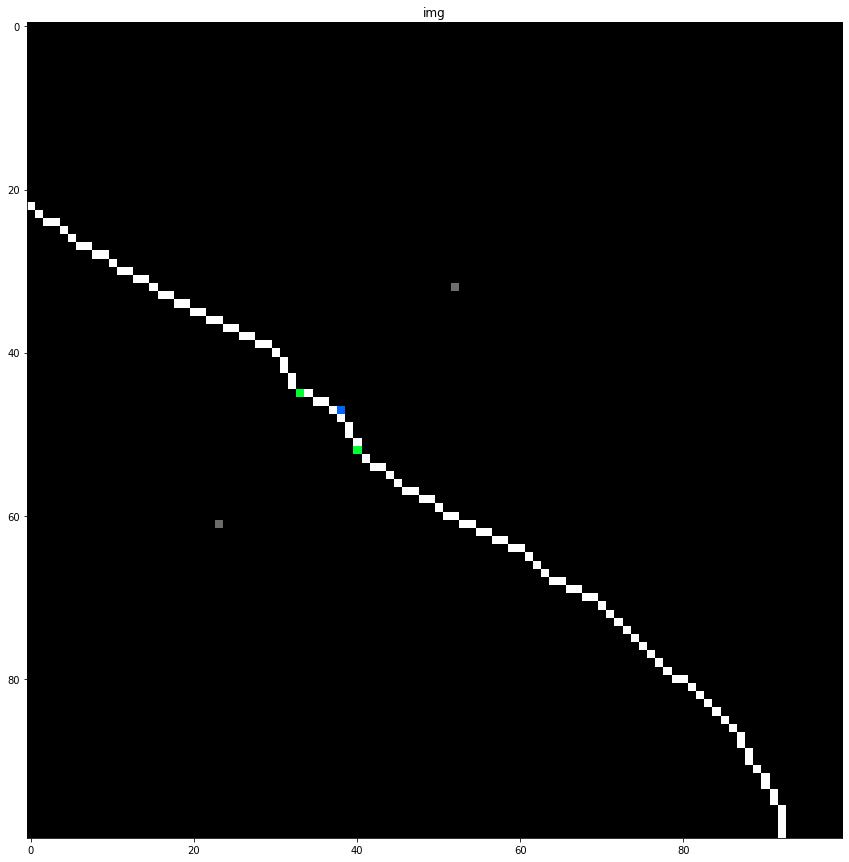

In [38]:
import math

exc = np.zeros(img.shape, np.uint8)

def drawline(img, point, color=(0, 255, 0)):
    cv.line(img, point, point, color, thickness=1)

draw_contour(exc, longest)

center_index = int(len(longest) / 2)

a = longest[center_index - 1][0]
b = longest[center_index][0]
c = longest[center_index + 1][0]

drawline(exc, (a[0], a[1]), color=(0, 255, 50))
drawline(exc, (b[0], b[1]), color=(0, 100, 255))
drawline(exc, (c[0], c[1]), color=(0, 255, 50))

def sidepoints(a, b, c, t):
    m = (c[0] - a[0]) / (c[1] - a[1])
    alpha = math.atan(- 1 / m)
    dy = math.sin(alpha)
    dx = math.cos(alpha)

    return [
        (int(b[y] + dy * t), int(b[x] + dx * t))
        for t in [t, -t]
    ]

for point in sidepoints(a, b, c, 20):
    p = img[point[0], point[1]]
    color = tuple(map(int, (p[0], p[1], p[2])))
    drawline(exc, (point[y], point[x]), color=color)


imshow(exc[550:650, 400:500])